In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

In [2]:
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

In [3]:
df = load_breast_cancer(as_frame=True).frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
len(df)

569

In [5]:
scale = StandardScaler()
columns = df.columns
y = df["target"].copy()
df = pd.DataFrame(scale.fit_transform(df))
df.columns = columns
df["target"] = y.copy()
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,0
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,0
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,0
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,0
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,0


In [6]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,569.000000,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,569.000000
mean,-1.373633e-16,6.868164e-17,-1.248757e-16,-2.185325e-16,-8.366672e-16,1.873136e-16,4.995028e-17,-4.995028e-17,1.748260e-16,4.745277e-16,...,1.248757e-17,-3.746271e-16,0.000000,-2.372638e-16,-3.371644e-16,7.492542e-17,2.247763e-16,2.622390e-16,-5.744282e-16,0.627417
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,0.483918
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-2.223994e+00,-1.693361e+00,-1.222423,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00,0.000000
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-7.486293e-01,-6.895783e-01,-0.642136,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01,0.000000
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-4.351564e-02,-2.859802e-01,-0.341181,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01,1.000000
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,6.583411e-01,5.402790e-01,0.357589,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01,1.000000
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,3.885905e+00,4.287337e+00,5.930172,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00,1.000000


In [7]:
X_t, X_test, Y_t, Y_test = train_test_split(df.drop("target", axis=1), df["target"], stratify=df["target"]) 

In [8]:
X_train, X_calib, Y_train, Y_calib = train_test_split(X_t, Y_t, stratify=Y_t)

In [9]:
logistic = LogisticRegression(max_iter=200, verbose=1, random_state=2)
logistic.fit(X_train, Y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21114D+02    |proj g|=  1.20755D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     32     34      1     0     0   5.868D-04   2.356D+01
  F =   23.560447772464606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(max_iter=200, random_state=2, verbose=1)

In [10]:
predictions = logistic.predict(X_test)
accuracy = accuracy_score(predictions, Y_test)

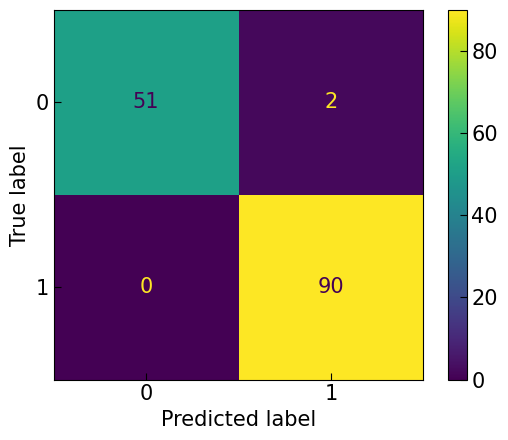

In [11]:
disp = ConfusionMatrixDisplay.from_estimator(
        logistic,
        X_test,
        Y_test,
)
plt.show()

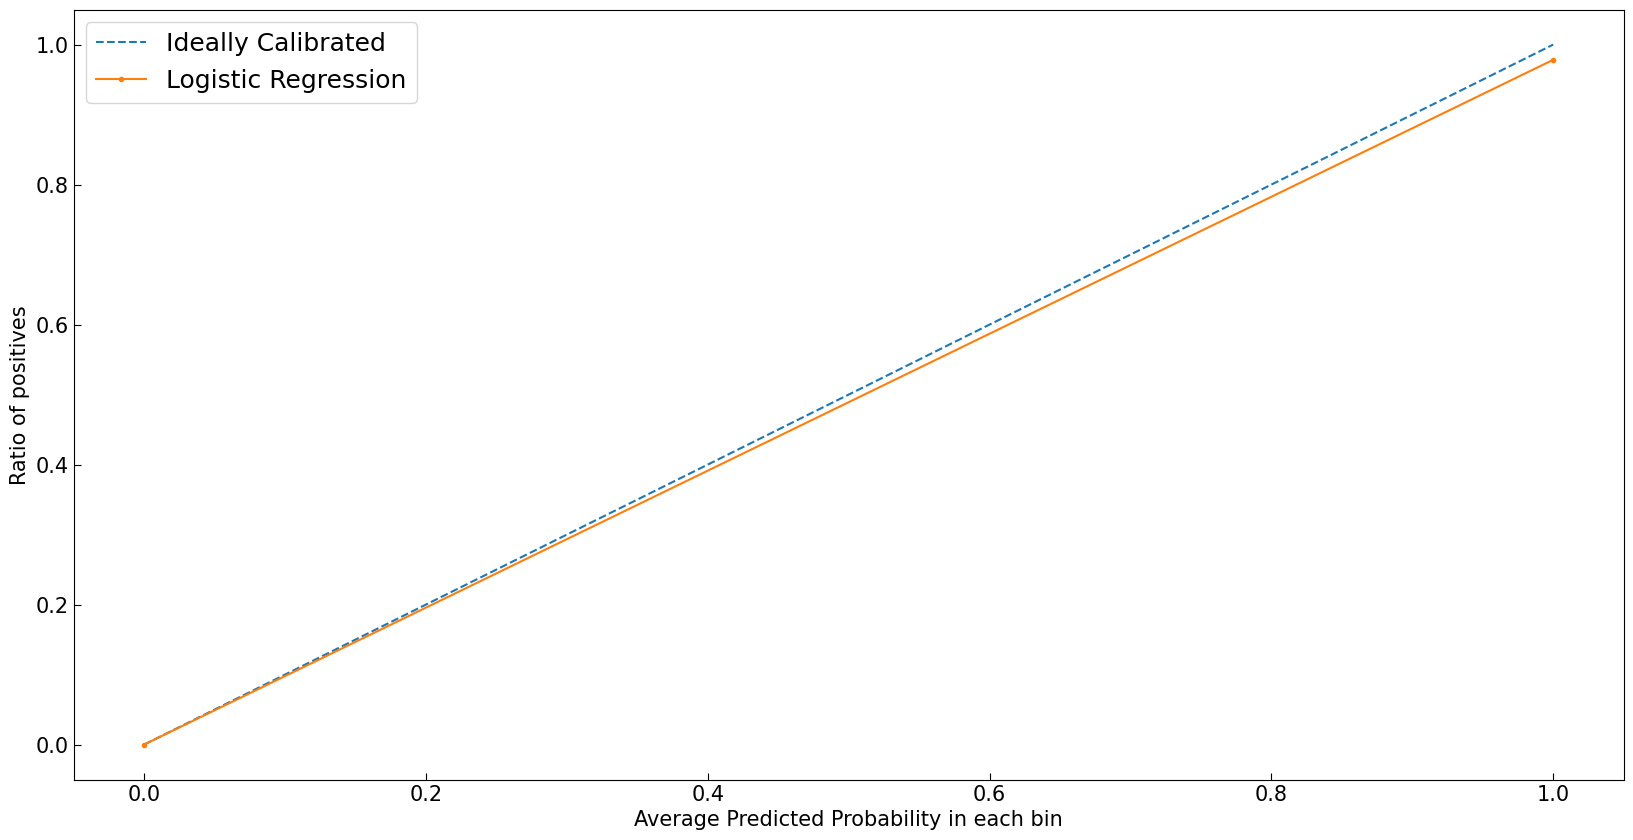

In [12]:
plt.figure(figsize=(20, 10))
prob_true, prob_pred = calibration_curve(Y_test, predictions, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve

plt.plot(prob_pred, prob_true, marker = '.', label = 'Logistic Regression')
 

leg = plt.legend(loc = 'upper left')

plt.xlabel('Average Predicted Probability in each bin')

plt.ylabel('Ratio of positives')
plt.show()
plt.show()

In [13]:
def venn_abers(trained_classifier, calibration_features, test_instance, calibration_labels):
    if type(test_instance) == pd.Series:
        test_instance = pd.DataFrame(test_instance).T
    calibrations = trained_classifier.predict_proba(calibration_features)
    predictions = trained_classifier.predict_proba(test_instance)
    interval = []
    scores = pd.DataFrame()
    scores["s"] = calibrations[:, 1]
    scores["y"] = calibration_labels.to_numpy()
    score = pd.DataFrame()
    score["s"] = predictions[:, 1]
    interval = []
    for i in [0, 1]:
        score["y"] = i
        train = pd.concat([scores, score], ignore_index=True)
        g = IsotonicRegression()
        g_scores = g.fit_transform(train["s"], train["y"])
        interval.append(np.round(g.predict(score["s"])[0], 3))
    return interval

In [14]:
venn_abers(logistic, X_calib, X_test[:1], Y_calib)

[0.98, 1.0]

In [15]:
X_test_after = X_test.copy()
X_test_after["interval"] = X_test_after.apply(lambda x: venn_abers(logistic, X_calib, x, Y_calib), axis=1)
X_test_after["proba"] = logistic.predict_proba(X_test)[:, 1]
X_test_after["Y"] = Y_test.copy()
dff = X_test_after[["Y", "interval", "proba"]].copy()

In [16]:
dff.head()

,Y,interval,proba
318,1,"[0.98, 1.0]",9.996464e-01
17,0,"[0.0, 0.042]",5.009557e-05
60,1,"[0.984, 1.0]",9.999115e-01
308,1,"[0.981, 1.0]",9.998219e-01
352,0,"[0.0, 0.028]",6.538054e-13


In [17]:
dff["inf_prob"] = dff["interval"].apply(lambda x: x[0])
dff["sup_prob"] = dff["interval"].apply(lambda x: x[1])
dff["genuine"] = dff.apply(lambda x: x["sup_prob"]/(1-x["inf_prob"]+x["sup_prob"]), axis=1)
dff.head()

,Y,interval,proba,inf_prob,sup_prob,genuine
318,1,"[0.98, 1.0]",9.996464e-01,0.980,1.000,0.980392
17,0,"[0.0, 0.042]",5.009557e-05,0.000,0.042,0.040307
60,1,"[0.984, 1.0]",9.999115e-01,0.984,1.000,0.984252
308,1,"[0.981, 1.0]",9.998219e-01,0.981,1.000,0.981354
352,0,"[0.0, 0.028]",6.538054e-13,0.000,0.028,0.027237


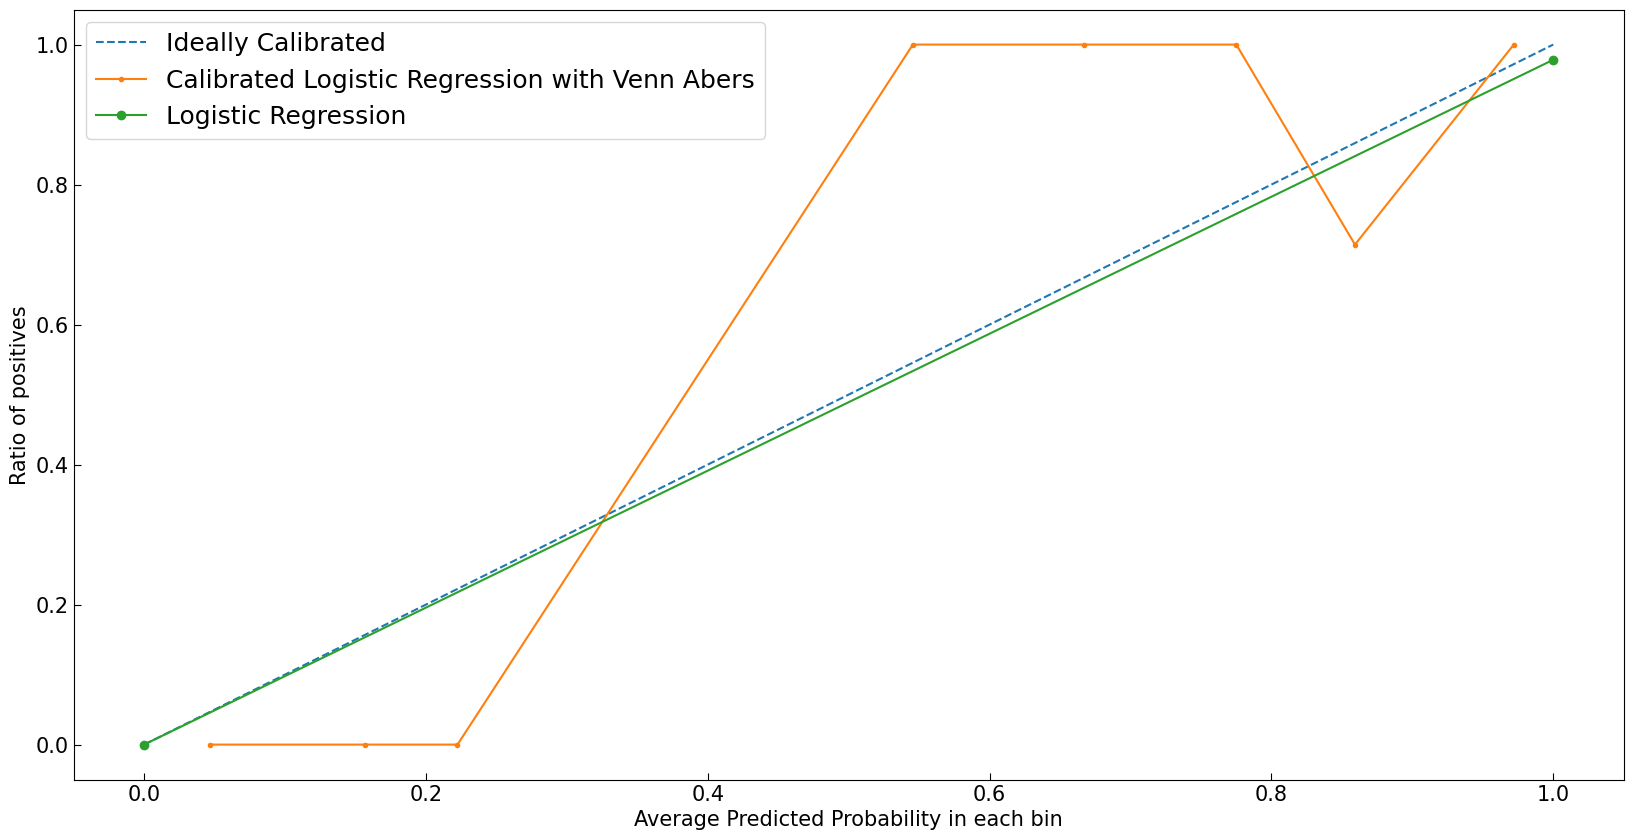

In [18]:
v_prob_true, v_prob_pred = calibration_curve(Y_test.values, dff["genuine"], n_bins=10)
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
plt.plot(v_prob_pred, v_prob_true, marker = '.', label = 'Calibrated Logistic Regression with Venn Abers')
plt.plot(prob_pred, prob_true, marker = 'o', label = 'Logistic Regression')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [19]:
import torch
from torch import nn
from collections import OrderedDict
import tensorflow as tf

2022-11-22 23:35:39.039409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Sequential(OrderedDict({
            'linear': nn.Linear(in_features=30, out_features=4),
            'relu': nn.ReLU(inplace=True),
        }))
        self.hidden_layer = nn.Linear(in_features=4, out_features=1)
        self.output_layer = nn.Sigmoid()
        self.losses = {}
        self.accuracies = {}
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        y_pred = self.output_layer(y)
        return y_pred
    
    def __initiate_loss_and_accuracy_dicts(self, n_epochs):
        for i in range(n_epochs):
            self.losses[i] = 0
            self.accuracies[i] = 0
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        self.__initiate_loss_and_accuracy_dicts(n_epochs=epochs)
        myDs=MyDataset(x_train=x_train, y_train=y_train)
        train_loader=torch.utils.data.DataLoader(myDs,batch_size=10,shuffle=False)
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        for e in range(epochs):
            n_batches = len(train_loader)
            print(f'Epoch {e+1}/{epochs}')
            pbar = tf.keras.utils.Progbar(target=n_batches)
            for idx, batch in enumerate(train_loader):
                x, y = batch
                optimizer.zero_grad()
                outputs = self(x)
                loss = nn.BCELoss()
                loss_value = loss(outputs, y.reshape(-1, 1))
                loss_value.backward()
                optimizer.step()
                accuracy = accuracy_score(
                    y_true=y,
                    y_pred=outputs.reshape(-1).detach().numpy().round()
                )
                self.losses[e] += loss_value.detach().numpy()
                self.accuracies[e] += accuracy
                curr_idx = idx+1
                pbar.update(
                    idx,
                    values=[
                        ("loss", loss_value.detach().numpy()),
                        ("accuracy", accuracy)
                    ]
                )
            self.losses[e] = self.losses[e]/n_batches
            self.accuracies[e] = self.accuracies[e]/n_batches
            pbar.update(n_batches, values=None) 
            
    def predict_probas(self, x, as_numpy=False): 
        outputs = self(x)
        if as_numpy:
            outputs = outputs.detach().numpy()
        return outputs

In [21]:
class Simple_Neural_Net_bis(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Sequential(OrderedDict({
            'linear': nn.Linear(in_features=30, out_features=4),
            'relu': nn.ReLU(inplace=True),
        }))
        self.hidden_layer = nn.Linear(in_features=4, out_features=1)
        self.output_layer = nn.Sigmoid()
        self.losses = []
        self.accuracies = []
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        y_pred = self.output_layer(y)
        return y_pred
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        loss = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        for _ in range(epochs):
            outputs = self(x_train)
            loss_value = loss(outputs, y_train.reshape(-1, 1))
            accuracy = accuracy_score(
                y_true=y_train, y_pred=outputs.reshape(-1).detach().numpy().round()
            )
            loss_value.backward()
            optimizer.step()
            self.losses.append(loss_value.detach().numpy())
            self.accuracies.append(accuracy)            
    def predict_probas(self, x, as_numpy=False):
        outputs = self(x)
        if as_numpy:
            outputs = outputs.detach().numpy()
        return outputs


In [22]:
class MyDataset(torch.utils.data.Dataset):
 
    def __init__(self, x_train, y_train):
        x=x_train.values
        y=y_train.values

        self.X_train=torch.tensor(x,dtype=torch.float32)
        self.Y_train=torch.tensor(y,dtype=torch.float32)

    def __len__(self):
        return len(self.Y_train)
   
    def __getitem__(self,idx):
        return self.X_train[idx],self.Y_train[idx]

In [23]:
model = Simple_Neural_Net()

epochs = 10
input_dim = 30 
output_dim = 1
learning_rate = 0.15

model.fit(x_train=X_train, y_train=Y_train, epochs=epochs, learning_rate=learning_rate)

Epoch 1/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4373 - accuracy: 0.8153
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1354 - accuracy: 0.9656
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0887 - accuracy: 0.9844
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0736 - accuracy: 0.9875
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9875
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9875
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0567 - accuracy: 0.9875
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0528 - accuracy: 0.9875
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.9875
Epoch 10/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0471 - accuracy: 0.9906


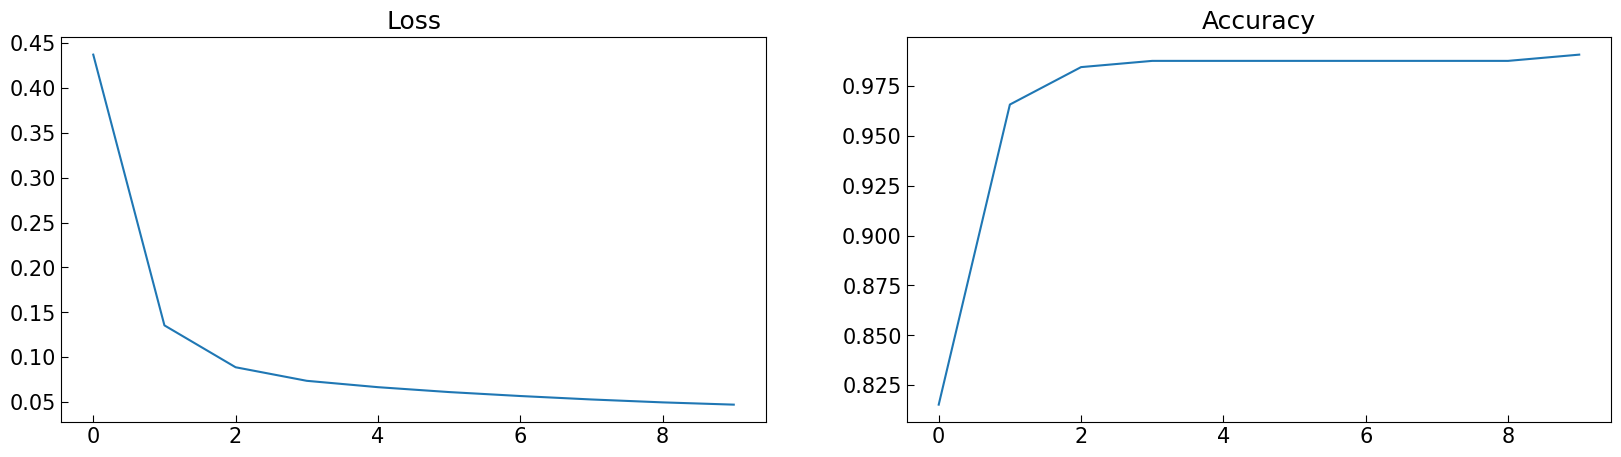

In [24]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(x=[i for i in range(epochs)], y=[float(loss) for loss in model.losses.values()], ax=axes[0]).set(title="Loss")
sns.lineplot(x=[i for i in range(epochs)], y=model.accuracies.values(), ax=axes[1]).set(title="Accuracy")
plt.show()

In [25]:
predictions = model.predict_probas(torch.from_numpy(X_calib.values.astype(np.float32)), as_numpy=True)

In [26]:
prob_true, prob_pred = calibration_curve(Y_calib.values, predictions, n_bins=10)

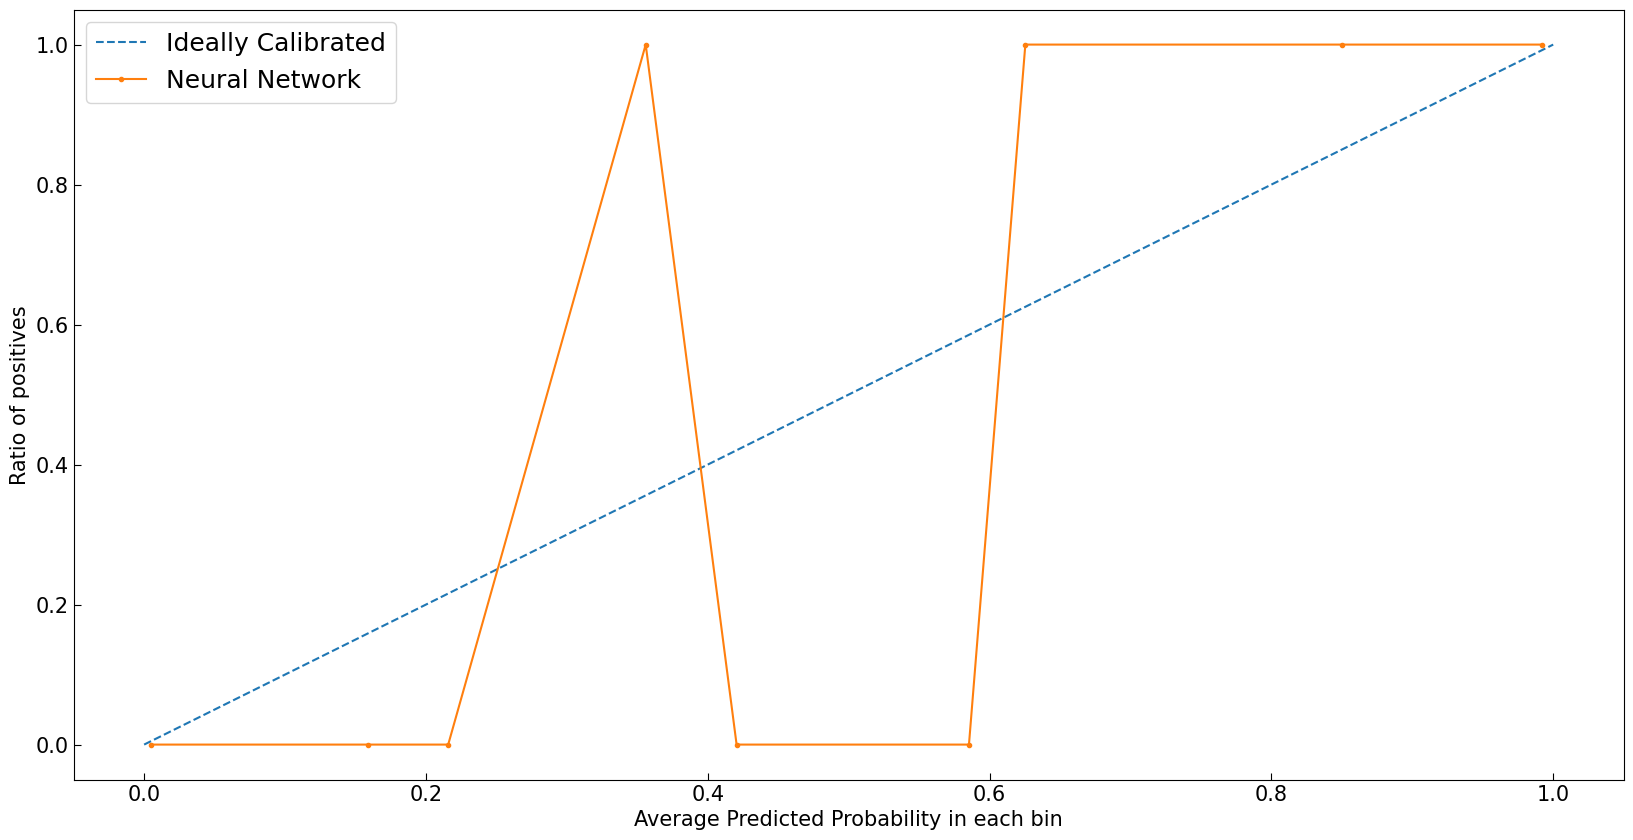

In [27]:
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve

plt.plot(prob_pred, prob_true, marker = '.', label = 'Neural Network')
 

leg = plt.legend(loc = 'upper left')

plt.xlabel('Average Predicted Probability in each bin')

plt.ylabel('Ratio of positives')
plt.show()


In [28]:
def venn_abers_pytorch(trained_classifier, calibration_features, test_instance, calibration_labels):
    calibrations = trained_classifier.predict_probas(calibration_features, as_numpy=True)
    predictions = trained_classifier.predict_probas(test_instance, as_numpy=True)
    interval = []
    scores = pd.DataFrame()
    scores["s"] = calibrations[:, 0]
    scores["y"] = calibration_labels.to_numpy()
    score = pd.DataFrame()
    score["s"] = predictions[:, 0]
    interval = []
    
    for i in [0, 1]:
        score["y"] = i
        train = pd.concat([scores, score], ignore_index=True)
        g = IsotonicRegression()
        g_scores = g.fit_transform(train["s"], train["y"])
        interval.append(np.round(g.predict(score["s"])[0], 3))
    return interval

In [29]:
venn_abers_pytorch(
    model,
    torch.from_numpy(X_calib.values.astype(np.float32)),
    torch.from_numpy(X_test[0:1].values.astype(np.float32)),
    Y_calib
)

[0.983, 1.0]

In [30]:
X_test_after = X_test.copy()
X_test_after["interval"] = X_test_after.apply(
    lambda x: venn_abers_pytorch(
        model,
        torch.from_numpy(X_calib.values.astype(np.float32)),
        torch.from_numpy(x.values.reshape(1, -1).astype(np.float32)),
        Y_calib)
    ,
    axis=1
)
X_test_after["proba"] = model.predict_probas(torch.from_numpy(X_test.values.astype(np.float32)), as_numpy=True)[:, 0]
X_test_after["Y"] = Y_test.copy()
dff = X_test_after[["Y", "interval", "proba"]].copy()

In [31]:
dff.head()

,Y,interval,proba
318,1,"[0.983, 1.0]",9.999102e-01
17,0,"[0.0, 0.042]",1.624438e-05
60,1,"[0.982, 1.0]",9.998478e-01
308,1,"[0.979, 1.0]",9.993587e-01
352,0,"[0.0, 0.027]",4.341117e-12


In [32]:
dff["inf_prob"] = dff["interval"].apply(lambda x: x[0])
dff["sup_prob"] = dff["interval"].apply(lambda x: x[1])
dff["genuine"] = dff.apply(lambda x: x["sup_prob"]/(1-x["inf_prob"]+x["sup_prob"]), axis=1)
dff.head()

,Y,interval,proba,inf_prob,sup_prob,genuine
318,1,"[0.983, 1.0]",9.999102e-01,0.983,1.000,0.983284
17,0,"[0.0, 0.042]",1.624438e-05,0.000,0.042,0.040307
60,1,"[0.982, 1.0]",9.998478e-01,0.982,1.000,0.982318
308,1,"[0.979, 1.0]",9.993587e-01,0.979,1.000,0.979432
352,0,"[0.0, 0.027]",4.341117e-12,0.000,0.027,0.026290


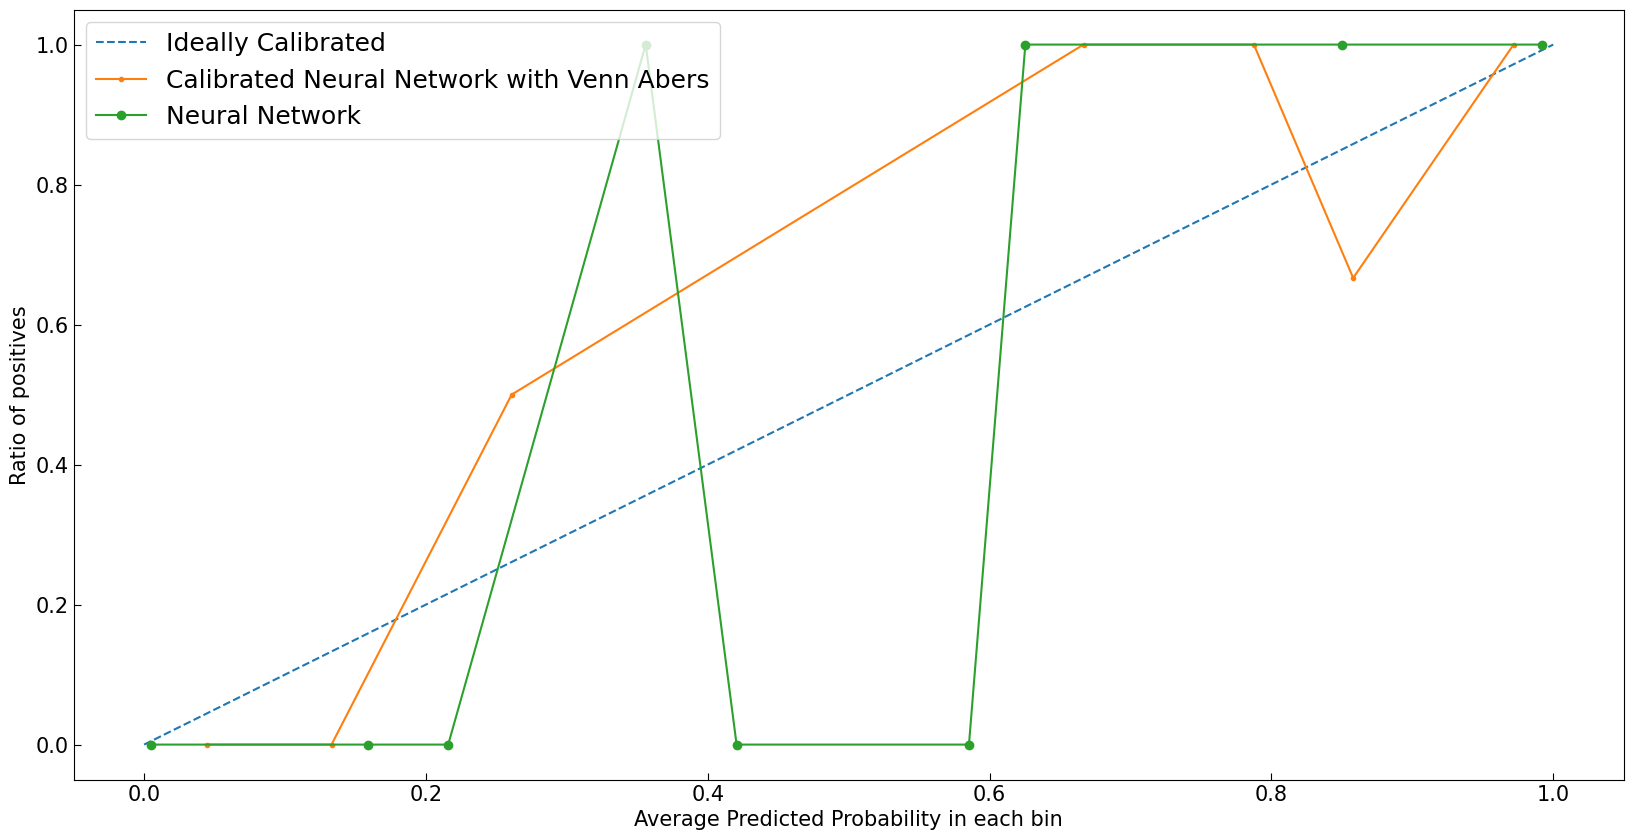

In [33]:
v_prob_true, v_prob_pred = calibration_curve(Y_test.values, dff["genuine"], n_bins=10)
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
plt.plot(v_prob_pred, v_prob_true, marker = '.', label = 'Calibrated Neural Network with Venn Abers')
plt.plot(prob_pred, prob_true, marker = 'o', label = 'Neural Network')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()